# Single-particle Eigenstate Thermolization in Polariton Hamiltonians. Photonic Wire Model
**Ribeiro Group Rotation Project A**

Brian Zhao, 09 Sept 2022

The following is adapted from Ribeiro, R. F. _Multimode Polariton Effects on Molecular Energy Transport and Spectral Fluctuations_. Commun Chem 2022, 5 (1), 1–10. https://doi.org/10.1038/s42004-022-00660-0.

### Model Hamiltonian
#### Cavity Hamiltonian
The empty cavity Hamiltonian is given by
$$
H_{\text{L}}=\sum_q \epsilon_q a_q^{\dagger}a_q,
$$
where
$$
\epsilon_q = \frac{\hbar c}{\sqrt{\epsilon}}\sqrt{q_0^2+q^2},
$$
where $q_0=\sqrt{(\pi/L_z)^2+(\pi/L_y)^2}$ is a constant, and $q=2\pi m/L$ ($m\in \mathcal{Z}$) are the _cavity modes_.

#### Matter Hamiltonian
The Hamiltonian for the molecules are given by
$$
H_{\text{M}}=\sum_{i=1}^{N_{\text{M}}}(\epsilon_{\text{M}}+\sigma_i)b_i^+b_i^-,
$$
where $b_i^+=|1_i\rangle\langle 0_i|$ and $b_i^-=|0_i\rangle\langle 1_i|$ creates and annihilates an excitation at the $i$-th molecule respectively, and $\sigma_i$ is drawn from a normal distribution with variance $\sigma^2$.

#### Light-matter Hamiltonian
Applying the Coulomb gauge in the rotating-wave approximation (ignoring double raising and lowering), we have
$$
H_{\text{LM}}=\sum_{j=1}^{N_{\text{M}}}\sum_q\frac{-i\Omega_{\text{R}}}{2}\sqrt{\frac{\epsilon_{\text{M}}}{N_{\text{M}}\epsilon_q}}\frac{\mu_j}{\mu_0}\left(e^{iqx_j}b_j^+a_q-e^{-iqx_j}a_q^{\dagger}b_j^- \right),
$$
where $\Omega_{\text{R}}=\mu_0\sqrt{\hbar\omega_0N_{\text{M}}/2\epsilon LL_yL_z}$, and $\mu_j$ is drawn from a normal distribution with variance $\sigma_{\mu}^2$.

We assume there is only one photon.

In [14]:
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt

q_to_ev = cst.c*cst.hbar/cst.e

def e_q(m,L,Ly,Lz,eps):
    return np.sqrt((np.pi/Lz)**2 + (np.pi/Ly)**2 + (2*np.pi*m/L)**2) * q_to_ev/np.sqrt(eps)

def total_hamil_naive(num_mol, omega_r, a, Ly, Lz, eps, em_mean, em_sigma, mu_sigma, f):
    try:
        assert (num_mol-1)%2 == 0
    except AssertionError:
        raise ValueError('num_mol needs to be 2N+1, where N is a positive integer!')
        
    n = int((num_mol-1)/2)
    L = num_mol*a
    
    # Initialise our random number generator
    rng = np.random.default_rng()
    
    # Light first then matter
    diag = np.concatenate((np.array([e_q(_,L,Ly,Lz,eps) for _ in range(-n,n+1)]),np.array([rng.normal(em_mean, em_sigma) for _ in range(num_mol)])))
    
    hamil = np.diag(diag) # Fill in the diagonal elements
    hamil = hamil.astype('complex128')
    
    # Fill in the off-diagonal elements
    # We just fill in the light-matter block (first quadrant), and take the complex conjugate for the third quadrant.
    for j in range(num_mol,2*num_mol):
        # This is the matter loop, we put it outside so mu_j only needs to be drawn once
        mu_j = rng.normal(1, mu_sigma)
        for q in range(num_mol):
            # omega_q was already computed in _diag
            omega_q = diag[q]
            hamil[q,j] = (omega_r/2)*np.sqrt(diag[j]/(num_mol*omega_q))*(mu_j)*np.exp(-((q*2*np.pi/(a*num_mol))*(a*(j-num_mol)+a*rng.uniform(-f,f))-0.5*np.pi)*1j)
            hamil[j,q] = np.conjugate(hamil[q,j])
    
    return diag[:num_mol], hamil

In [26]:
cav,hamil = total_hamil_naive(num_mol=5, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.0, em_sigma=0, mu_sigma=0, f=0)

In [27]:
eigs = np.linalg.eigh(hamil)[0]
print(eigs)

[ 1.85042217  1.99975008  1.99975008  1.99994129  1.99994129  2.15036423
 14.45584511 14.45584511 28.70280232 28.70280232]


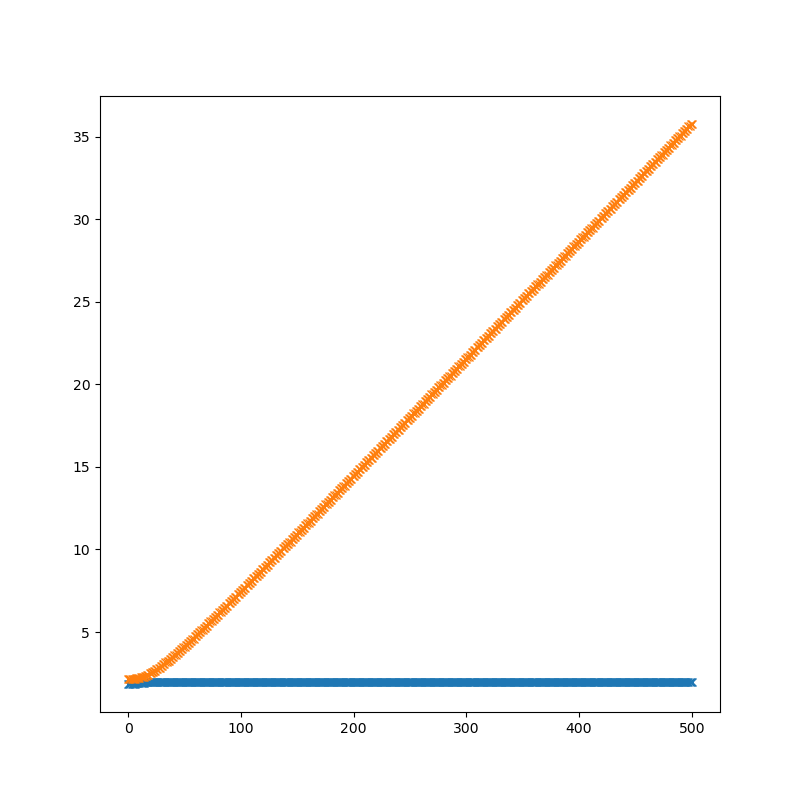

In [25]:
%matplotlib widget
f,ax = plt.subplots(figsize=(8,8))
ax.plot(eigs[:501],marker='x')
ax.plot(eigs[501:],marker='x')